In [5]:
import SpiceyPy as spice

In [7]:
spice.furnsh("/Users/klay6683/Dropbox/NotPublic/spice/"
             "cosp_1000_040701_040701/cas_2004_v21_040701_040701.tm")

## Get epoch time

Time coords taken from image label for N1467345444_2

In [8]:
import datetime as dt
time = dt.datetime.strptime('2004-183T03:37:05', '%Y-%jT%H:%M:%S')
time.isoformat()

'2004-07-01T03:37:05'

In [9]:
et = spice.utc2et(time.isoformat())
et

141925089.1840988

In [10]:
vertex, lt = spice.spkpos("CASSINI", et, "IAU_SATURN", 'LT', 'SATURN')

In [11]:
camid, fnd = spice.bodn2c("CASSINI_ISS_NAC")

In [12]:
shape, frame, borvec, no, corners = spice.getfov(camid, 4, 1000, 1000)

In [13]:
corners

array([[ 0.00305431,  0.00305431,  0.99999067],
       [-0.00305431,  0.00305431,  0.99999067],
       [-0.00305431, -0.00305431,  0.99999067],
       [ 0.00305431, -0.00305431,  0.99999067]])

In [14]:
rotmat = spice.pxform('CASSINI_ISS_NAC', 'IAU_SATURN', et)

In [15]:
normal = np.array([0.,0.,1.])
point = np.zeros(3)
plane = spice.nvp2pl(normal, point)

In [16]:
corner_coords = []
for corner in corners:
    direction = np.matrix.dot(rotmat, corner)
    nxpts, xpt = spice.inrypl(vertex, direction, plane)
    corner_coords.append(xpt)

In [17]:
%matplotlib inline

In [18]:
x = [i[0] for i in corner_coords]
y = [i[1] for i in corner_coords]

In [19]:
import matplotlib

(118200, 118900)

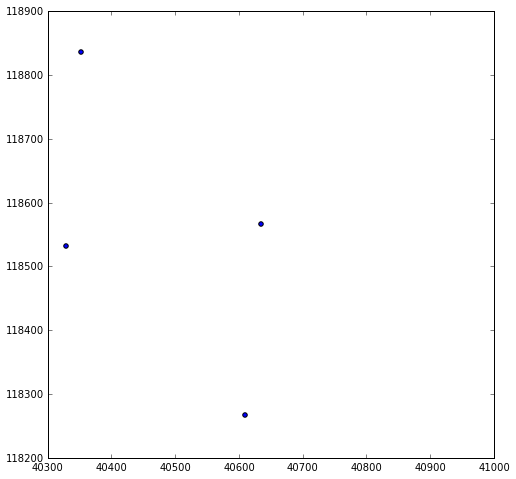

In [24]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(x,y)
ax.ticklabel_format(useOffset=False)
ax.set_xlim(40300, 41000)
ax.set_ylim(118200, 118900)

In [21]:
corner_coords

[array([  40328.90583239,  118532.51029137,       0.        ]),
 array([  40352.1582488 ,  118836.53717777,       0.        ]),
 array([  40634.73041113,  118566.55790563,       0.        ]),
 array([  40609.83034545,  118267.3102113 ,       0.        ])]

In [27]:
for t in [(0,1), (0,3), (1,2),(2,3)]:
    print(spice.vnorm(corner_coords[t[0]]-corner_coords[t[1]])/1024)

0.2977683389792582
0.37727386839152205
0.38165461136779305
0.2932440045320298
